# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna as opt

# Importing the data

In [2]:
df = pd.read_csv("./../data/space.csv")

# Categorically Encoding "class"

In [3]:
df['class'] = df['class'].astype('category').cat.codes

In [4]:
X = df.drop(["class"], axis=1)
y = df["class"]

# Train_test_split 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna hyperparameter optimalization

In [6]:
#use optuna to tune the hyperparameters
def objective(trial):
    param = {
            "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
            'nthread' : -1
        }
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return score.mean()


study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

[I 2022-10-12 10:23:25,963] A new study created in memory with name: no-name-359bcae4-f983-4a05-a82e-f8075214ee70
[I 2022-10-12 10:23:38,367] Trial 0 finished with value: 0.977197312848839 and parameters: {'n_estimators': 427, 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.26233098199157123, 'colsample_bytree': 0.42000000000000004}. Best is trial 0 with value: 0.977197312848839.
[I 2022-10-12 10:25:14,491] Trial 1 finished with value: 0.9775161522158978 and parameters: {'n_estimators': 598, 'max_depth': 16, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 1, 'learning_rate': 0.021814370603485674, 'colsample_bytree': 0.28}. Best is trial 1 with value: 0.9775161522158978.


# Using optuna hyperparams to make a model and validate with f1 score

In [7]:
#make a model with the best hyperparameters
model = xgb.XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.28,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.021814370603485674, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=598, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)

# Predicting on the test set with the model

In [8]:
y_pred = model.predict(X_test)

# Using cross-validation to get an accurate score

In [9]:
#get f1 score of the model
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
print("F1 score: ", scores.mean())

F1 score:  0.9784905646096306


# Plot the feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

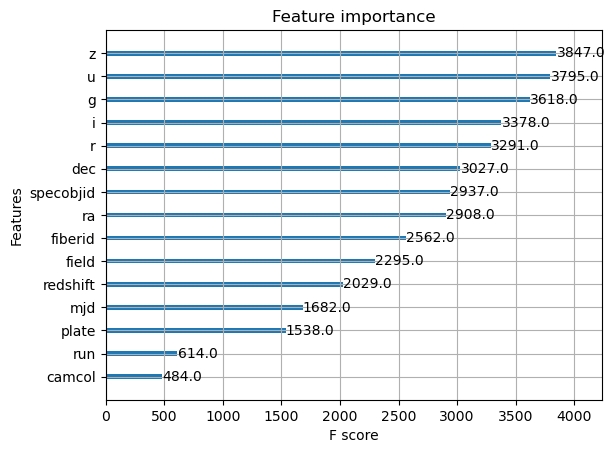

In [10]:
xgb.plot_importance(model)

# Plotting the confusion matrix

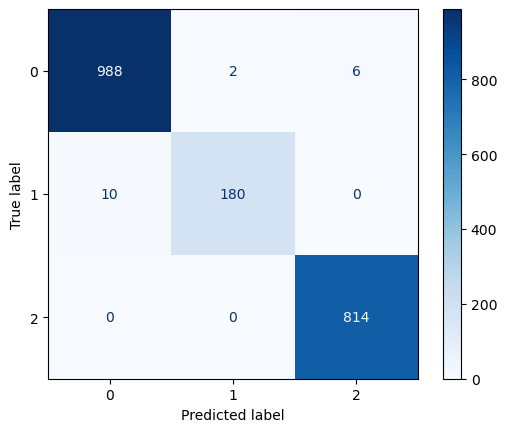

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

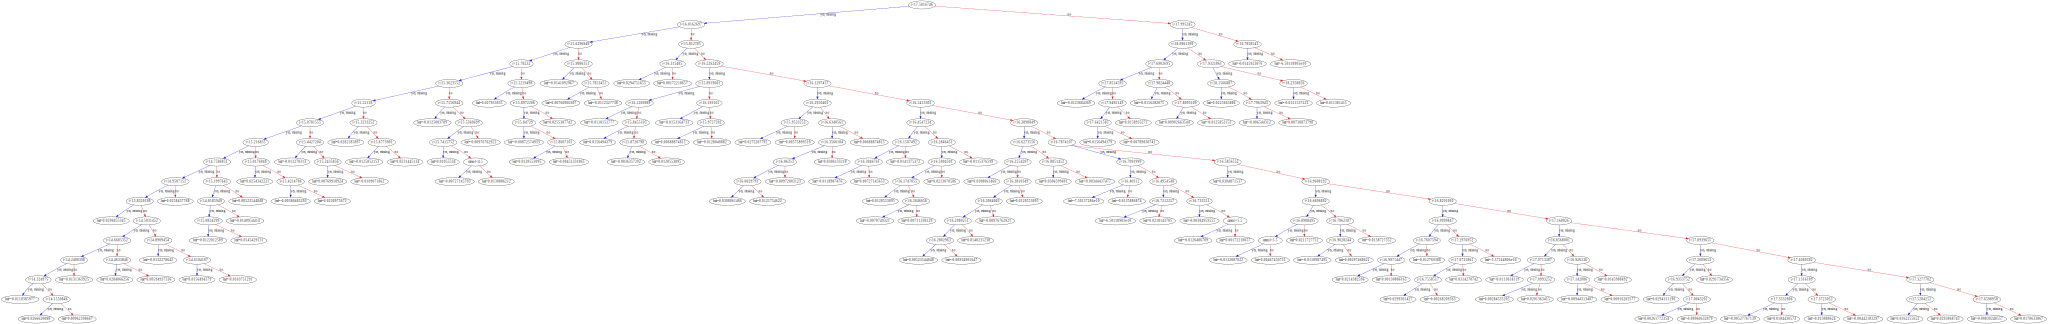

In [12]:
xgb.to_graphviz(model, num_trees=0)